# EDA (Exploratory Data Analysis)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import warnings
from textblob import TextBlob
import boto3
from io import StringIO

In [7]:
warnings.filterwarnings("ignore")

In [8]:
# Load environment variables
from dotenv import load_dotenv
import os

load_dotenv()

True

In [9]:
# Initialize a session using Amazon S3
s3_client = boto3.client('s3', 
                         aws_access_key_id=os.getenv('aws_access_key_id'),
                         aws_secret_access_key=os.getenv('aws_secret_access_key'))

# Name of the S3 bucket
bucket_name = 'new-british-airline'

def get_recent_csv_files(bucket_name, num_files=2):
    response = s3_client.list_objects_v2(Bucket=bucket_name)
    csv_files = [
        {'Key': obj['Key'], 'LastModified': obj['LastModified']}
        for obj in response.get('Contents', [])
        if obj['Key'].endswith('.csv')
    ]
    return [file['Key'] for file in sorted(csv_files, key=lambda x: x['LastModified'], reverse=True)[:num_files]]

def read_csv_to_df(bucket_name, file_key):
    csv_obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    return pd.read_csv(StringIO(csv_obj['Body'].read().decode('utf-8')))

# Get the most recent CSV file and read it into a DataFrame
recent_csv_file = get_recent_csv_files(bucket_name, num_files=1)[0]
df = read_csv_to_df(bucket_name, recent_csv_file)

In [10]:
df.dtypes

id                    int64
date_review          object
day_review            int64
month_review         object
month_review_num      int64
year_review           int64
verified               bool
name                 object
month_fly            object
month_fly_num       float64
year_fly            float64
month_year_fly       object
country              object
aircraft             object
aircraft_1           object
aircraft_2           object
type                 object
seat_type            object
route                object
origin               object
destination          object
transit              object
seat_comfort        float64
cabin_serv          float64
food                float64
ground_service      float64
wifi                float64
money_value           int64
score               float64
experience           object
recommended            bool
review               object
dtype: object

In [11]:
df.month_year_fly =  pd.to_datetime(df['month_year_fly'])
df.date_review = pd.to_datetime(df['date_review'])

In [12]:
df.dtypes

id                           int64
date_review         datetime64[ns]
day_review                   int64
month_review                object
month_review_num             int64
year_review                  int64
verified                      bool
name                        object
month_fly                   object
month_fly_num              float64
year_fly                   float64
month_year_fly      datetime64[ns]
country                     object
aircraft                    object
aircraft_1                  object
aircraft_2                  object
type                        object
seat_type                   object
route                       object
origin                      object
destination                 object
transit                     object
seat_comfort               float64
cabin_serv                 float64
food                       float64
ground_service             float64
wifi                       float64
money_value                  int64
score               

In [13]:
df.head()

,id,date_review,day_review,month_review,month_review_num,year_review,verified,name,month_fly,month_fly_num,...,seat_comfort,cabin_serv,food,ground_service,wifi,money_value,score,experience,recommended,review
0,0,2024-09-28,28,September,9,2024,True,Christopher Neep,September,9.0,...,4.0,5.0,2.0,3.0,NaN,2,3.5,Poor,True,British Airways World Traveller Plus (Premium ...
1,1,2024-09-25,25,September,9,2024,True,D Hane,September,9.0,...,3.0,4.0,1.0,3.0,1.0,1,2.4,Poor,False,BA is barely a step above low cost airlines. T...
2,2,2024-09-24,24,September,9,2024,False,John Brown,September,9.0,...,5.0,5.0,5.0,5.0,NaN,5,5.0,Good,True,Happy with the flight crew. Hadn't been on a p...
3,3,2024-09-22,22,September,9,2024,True,C Haddei,September,9.0,...,1.0,NaN,NaN,1.0,NaN,1,1.0,Poor,False,Horrible service from boarding to landing. I f...
4,4,2024-09-13,13,September,9,2024,False,Thomas Wilson,September,9.0,...,2.0,2.0,2.0,1.0,2.0,1,1.8,Poor,False,My wife and I are very disappointed with flyin...


## General Analysis

### Null Analysis

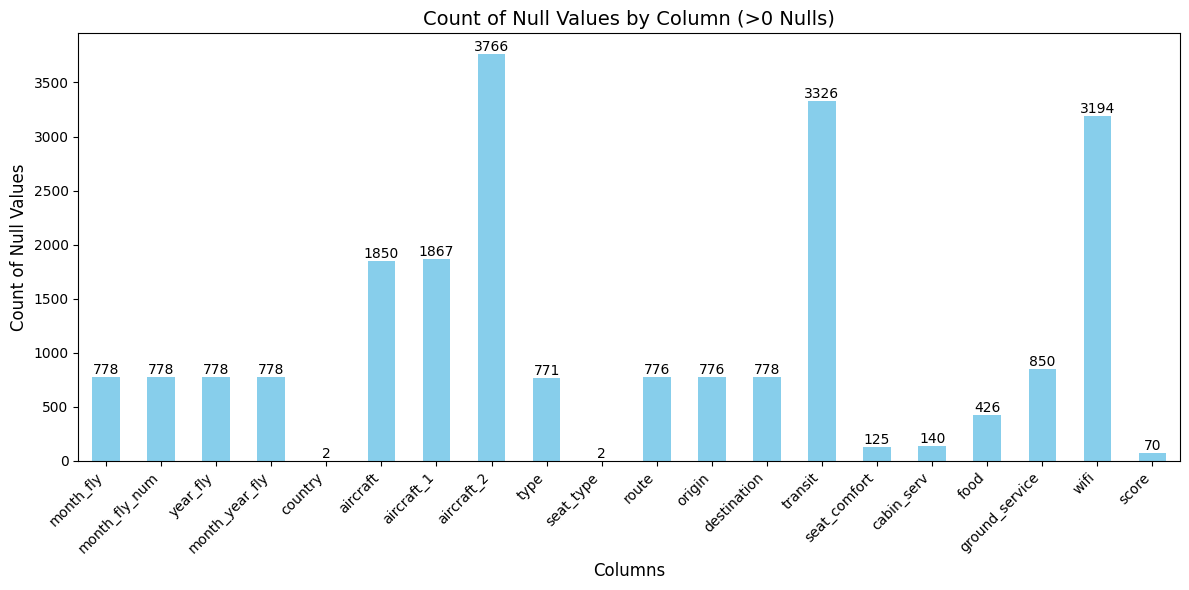

Percentage of null values in the dataset: 17.65%


In [14]:
# Count and filter null values
null_counts = df.isnull().sum()
null_counts_gt_zero = null_counts[null_counts > 0]

# Create bar plot of null counts
plt.figure(figsize=(12, 6))
ax = null_counts_gt_zero.plot(kind='bar', color='skyblue')

# Customize plot
plt.title('Count of Null Values by Column (>0 Nulls)', fontsize=14)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Count of Null Values', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(null_counts_gt_zero):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print percentage of nulls
total_cells = df.size
null_percentage = (null_counts.sum() / total_cells) * 100
print(f"Percentage of null values in the dataset: {null_percentage:.2f}%")

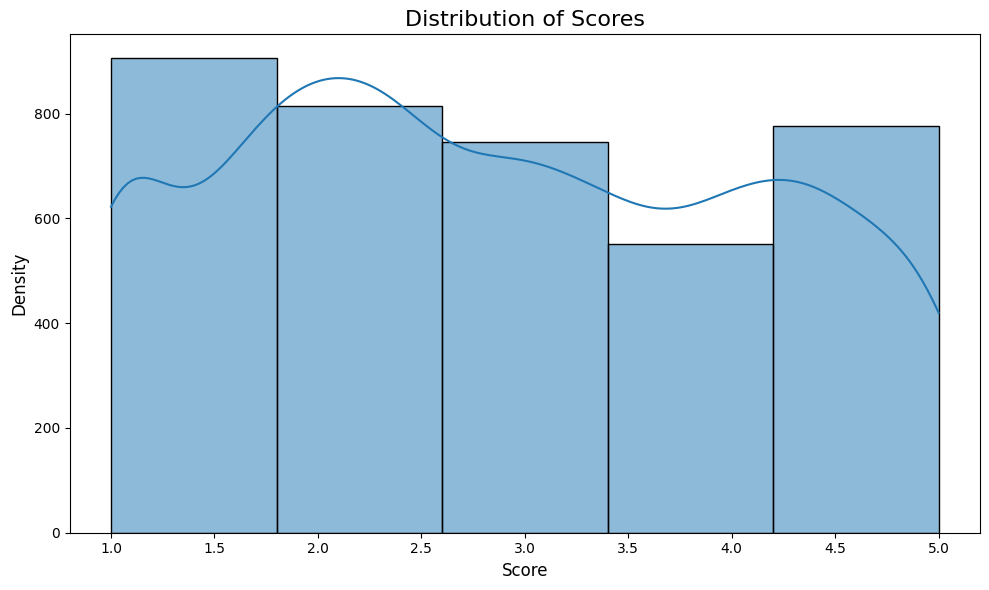

In [15]:
# Plotting distribution plot using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='score', kde=True, bins=5)
plt.title('Distribution of Scores', fontsize=16)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [16]:
# Define the columns for analysis
columns = ['seat_comfort', 'cabin_serv', 'food', 'ground_service', 'wifi', 'money_value', 'score']

# Compute summary statistics for selected columns
summary_df = df[columns].describe()

# Display the summary statistics
display(summary_df)

,seat_comfort,cabin_serv,food,ground_service,wifi,money_value,score
count,3740.000000,3725.000000,3439.000000,3015.000000,671.000000,3865.000000,3795.000000
mean,2.865775,3.243758,2.715033,2.763847,1.934426,2.670116,2.868112
std,1.361667,1.489731,1.438959,1.461274,1.340035,1.470236,1.218930
min,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.800000
50%,3.000000,3.000000,3.000000,3.000000,1.000000,3.000000,2.750000
75%,4.000000,5.000000,4.000000,4.000000,3.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## Service Analysis 

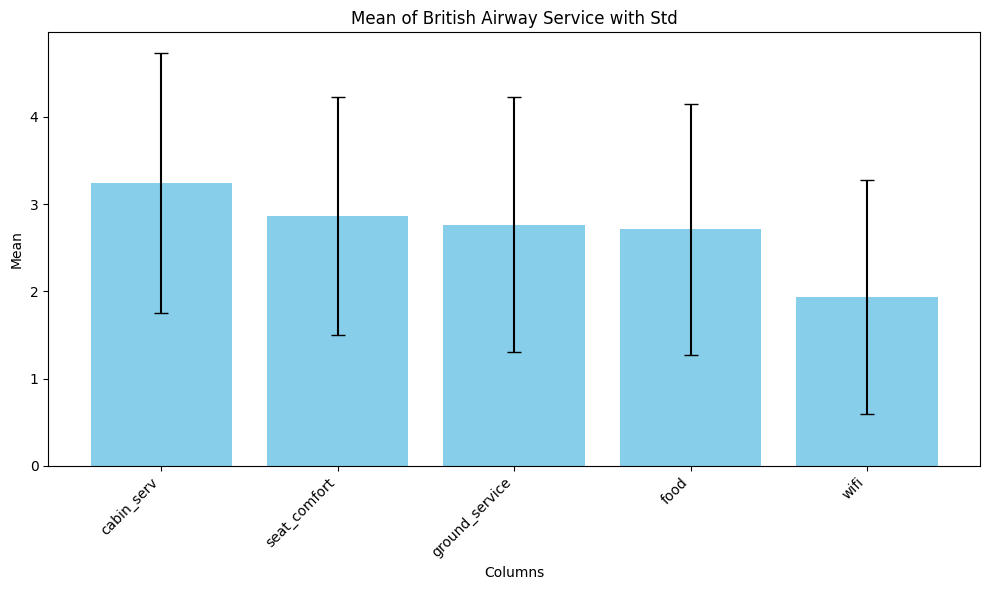

In [17]:
# Define the list of columns
columns = ['seat_comfort', 'cabin_serv', 'food', 'ground_service', 'wifi']

# Create a dictionary to store summary statistics for each column
summary_statistics = {}

# Compute summary statistics for each column
for column in columns:
    # Compute summary statistics for the current column
    summary_statistics[column] = df[column].describe()

# Extract the mean values and standard deviations for each column
means = [summary_statistics[column]['mean'] for column in columns]
stds = [summary_statistics[column]['std'] for column in columns]

# Sort the means and columns in descending order
sorted_means, sorted_columns = zip(*sorted(zip(means, columns), reverse=True))
sorted_stds = [summary_statistics[column]['std'] for column in sorted_columns]

# Plot the means of each column in descending order with error bars
plt.figure(figsize=(10, 6))
plt.bar(sorted_columns, sorted_means, color='skyblue', yerr=sorted_stds, capsize=5)  # Add error bars with std
plt.xlabel('Columns')
plt.ylabel('Mean')
plt.title('Mean of British Airway Service with Std')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [18]:
# Define a function to calculate sentiment polarity using TextBlob
def calculate_sentiment(text):
    """
    Calculate the sentiment polarity of a given text using TextBlob.
    
    Args:
    text (str): The input text to analyze.
    
    Returns:
    float: The sentiment polarity score, ranging from -1 (very negative) to 1 (very positive).
    """
    # Ensure the input is a string
    text = str(text)
    
    # Create a TextBlob object
    blob = TextBlob(text)
    
    # Return the sentiment polarity
    return blob.sentiment.polarity

In [19]:
# Apply the function to your review column
df['sentiment_score'] = df['review'].apply(calculate_sentiment)

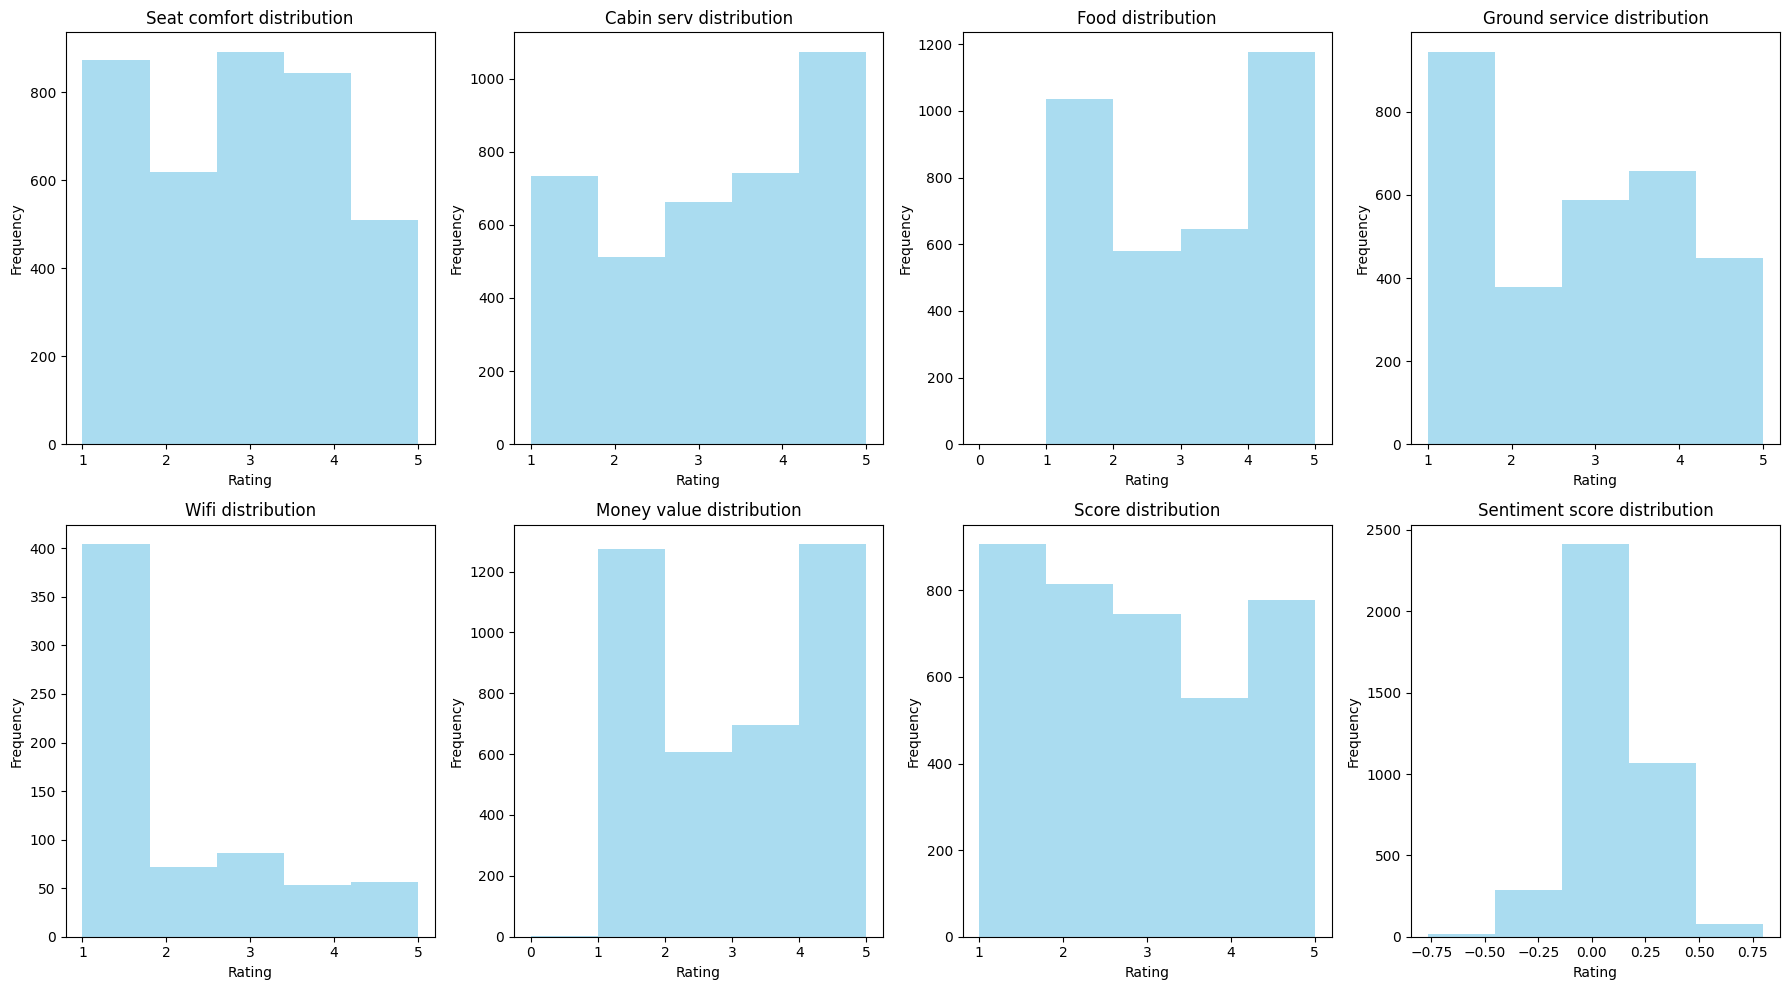

In [20]:
# Define columns of interest
columns = ['seat_comfort', 'cabin_serv', 'food', 'ground_service', 'wifi', 'money_value', 'score', 'sentiment_score']

# Set up the subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Iterate over each column and plot histograms
for i, column in enumerate(columns):
    axes[i].hist(df[column], bins=5, color='skyblue', alpha=0.7)
    axes[i].set_title(column.replace("_", " ").capitalize() + ' distribution')
    axes[i].set_xlabel('Rating')
    axes[i].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


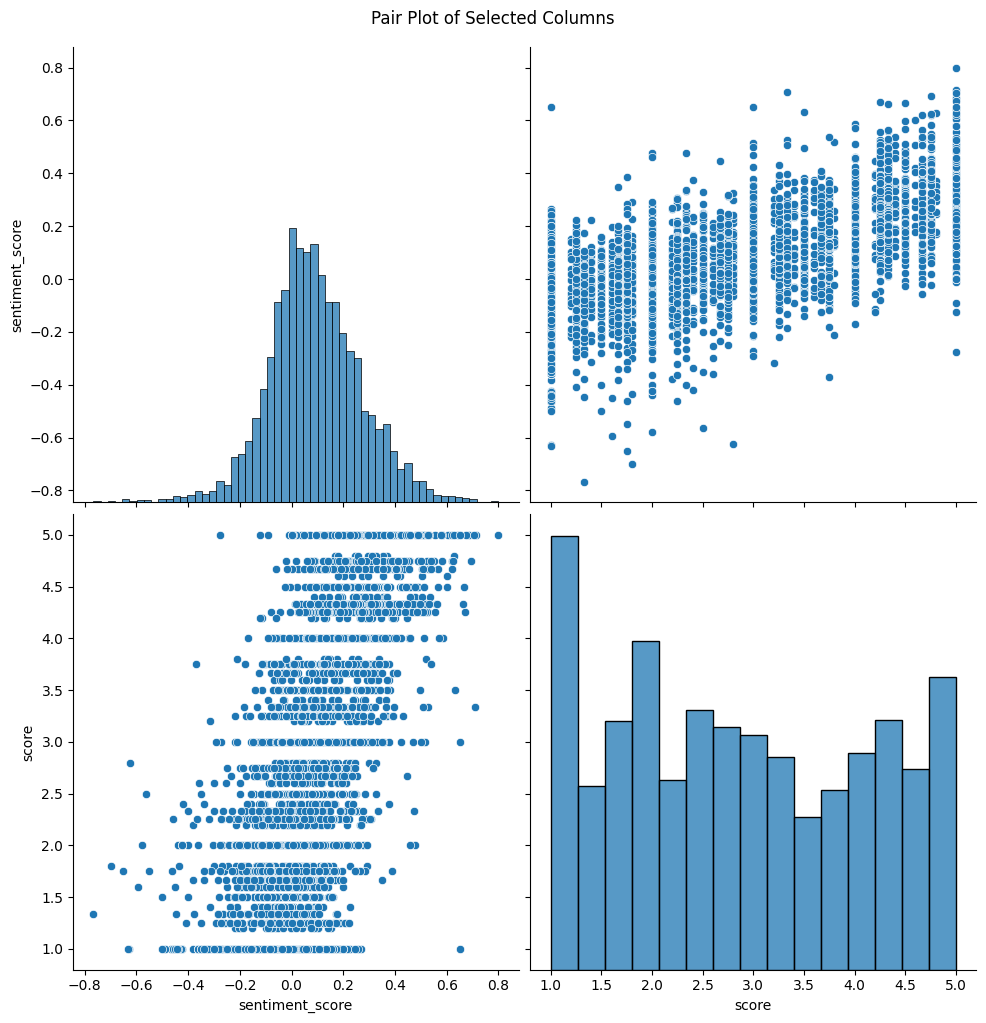

In [21]:
# Plotting pair plot using Seaborn
sns.pairplot(df[['sentiment_score','score']], height=5)
plt.suptitle('Pair Plot of Selected Columns', y=1.02)
plt.show()

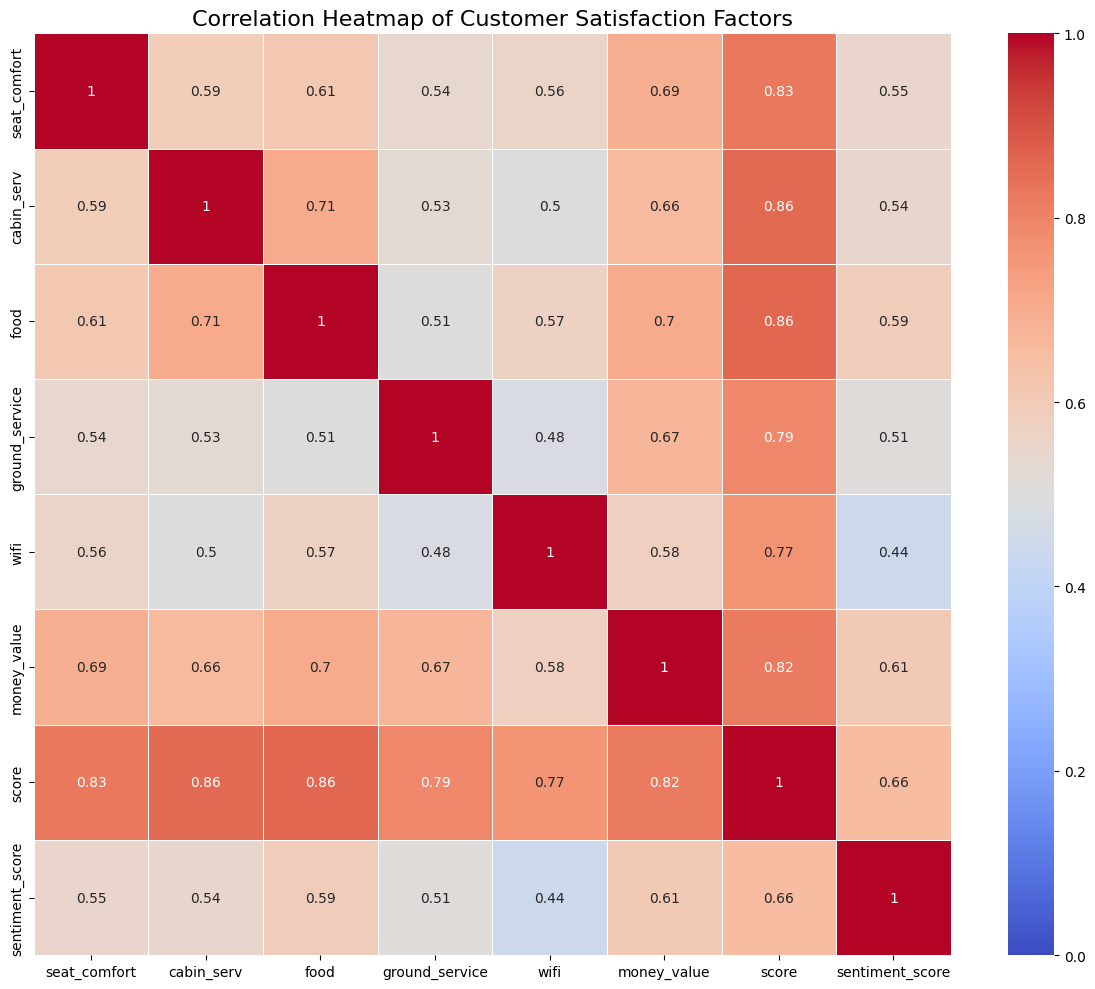

In [22]:
# Select columns for correlation analysis
selected_columns = ['seat_comfort', 'cabin_serv', 'food', 'ground_service', 'wifi', 'money_value', 'score', 'sentiment_score']
df_selected = df[selected_columns]

# Compute correlation matrix
correlation_matrix = df_selected.corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    linewidths=0.5, 
    vmin=0, 
    vmax=1,
    center=0.5
)
plt.title('Correlation Heatmap of Customer Satisfaction Factors', fontsize=16)
plt.tight_layout()
plt.show()

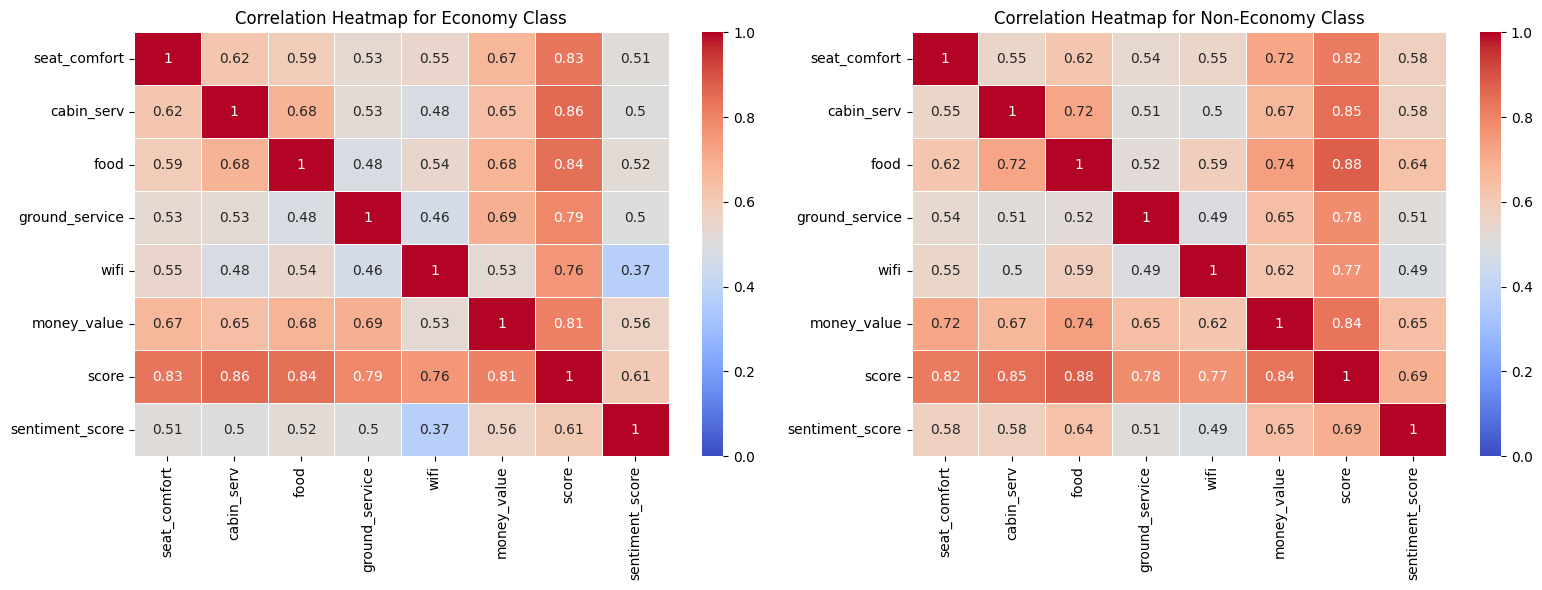

In [23]:
# Create subplots for Economy and Non-Economy Class correlation heatmaps
fig, (ax_economy, ax_non_economy) = plt.subplots(1, 2, figsize=(16, 6))

# Define seat types and corresponding axes
seat_types = ['Economy Class', 'Non-Economy Class']
axes = [ax_economy, ax_non_economy]

for seat_type, ax in zip(seat_types, axes):
    # Filter DataFrame based on seat type
    mask = df['seat_type'] == seat_type if seat_type == 'Economy Class' else df['seat_type'] != 'Economy Class'
    df_filtered = df[mask]
    
    # Calculate correlation matrix for selected columns
    corr_matrix = df_filtered[columns].corr()
    
    # Create heatmap
    sns.heatmap(corr_matrix, 
                ax=ax,
                annot=True, 
                cmap='coolwarm', 
                linewidths=0.5, 
                vmin=0, 
                vmax=1)
    
    ax.set_title(f'Correlation Heatmap for {seat_type}')

plt.tight_layout()
plt.show()

Key factors influencing customer satisfaction for non-economy class passengers are food and beverages, and seat comfort. For economy class passengers, ground service is the primary factor. These findings will be validated through feature engineering in the MoneyValueModel. This analysis will help prioritize improvements and tailor services to different passenger segments.

### Ground Experience (economy class)

Analyze negative ground service experiences for economy class passengers. We'll focus on economy class passengers who rated ground service poorly (2 or lower). This will help identify areas for improvement in the ground service experience

In [24]:
# Filter for Economy Class passengers with poor ground service ratings
economy_df = df[(df['seat_type'] == 'Economy Class') & (df['ground_service'] <= 2)]

In [25]:
economy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 796 entries, 4 to 3073
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                796 non-null    int64         
 1   date_review       796 non-null    datetime64[ns]
 2   day_review        796 non-null    int64         
 3   month_review      796 non-null    object        
 4   month_review_num  796 non-null    int64         
 5   year_review       796 non-null    int64         
 6   verified          796 non-null    bool          
 7   name              796 non-null    object        
 8   month_fly         795 non-null    object        
 9   month_fly_num     795 non-null    float64       
 10  year_fly          795 non-null    float64       
 11  month_year_fly    795 non-null    datetime64[ns]
 12  country           796 non-null    object        
 13  aircraft          313 non-null    object        
 14  aircraft_1        309 non-null

In [26]:
economy_df = economy_df[['verified', 'month_fly', 'month_fly_num', 'year_fly', 'month_year_fly', 'country', 'type','origin','destination','transit', 'ground_service', 'money_value', 'recommended', 'review']]

Analyze passenger routes to identify common origins, destinations, and transit points for economy class travelers with poor ground service ratings

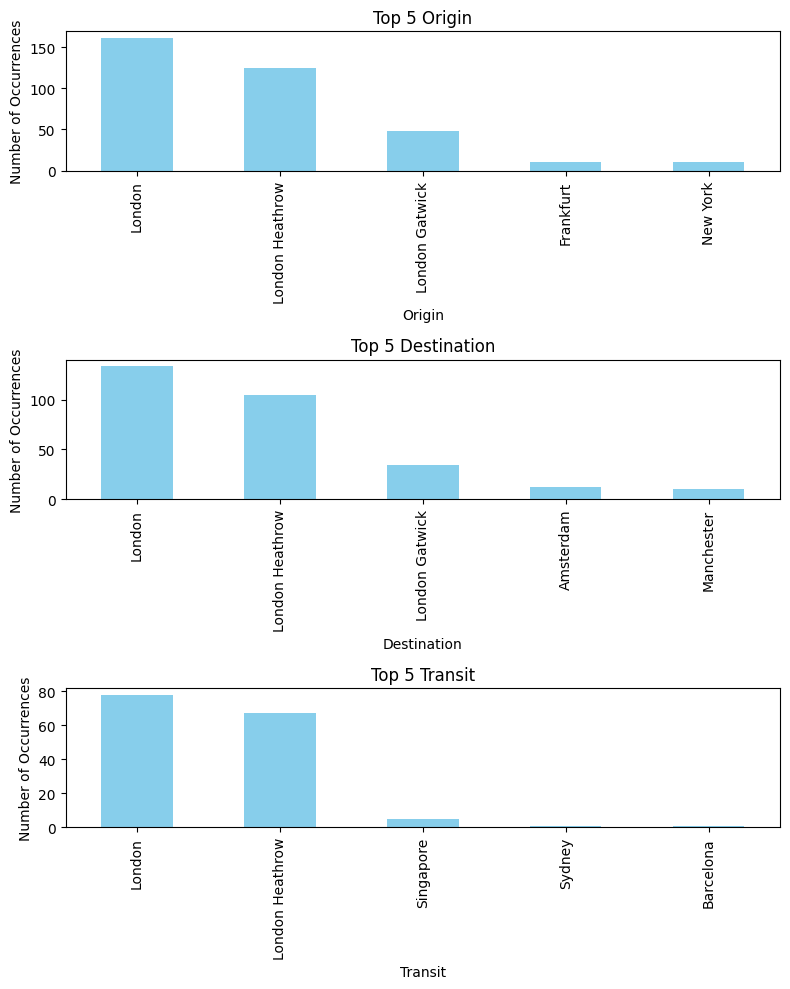

In [27]:
# Analyze top 5 origins, destinations, and transit points
columns_to_analyze = ['origin', 'destination', 'transit']
top_5_data = {col: economy_df[col].value_counts().nlargest(5) for col in columns_to_analyze}

# Set up the plot
fig, axes = plt.subplots(nrows=3, figsize=(8, 10))

# Create bar charts for each category
for index, (category, data) in enumerate(top_5_data.items()):
    data.plot(kind='bar', ax=axes[index], color='skyblue')
    
    # Customize subplot
    axes[index].set_title(f'Top 5 {category.capitalize()}')
    axes[index].set_xlabel(category.capitalize())
    axes[index].set_ylabel('Number of Occurrences')

# Optimize layout and display the plot
plt.tight_layout()
plt.show()


The analysis reveals that passengers with poor ground service ratings are predominantly traveling to or from London, with a particular concentration at Heathrow Airport and London Gatwick. This suggests that these major London airports may be focal points for addressing ground service issues in economy class.

#### London/London Heathrow Analysis

In [28]:
# Create a filter for flights involving London
london_filter = (
    economy_df['origin'].str.contains('London', case=False, na=False) |
    economy_df['destination'].str.contains('London', case=False, na=False) |
    economy_df['transit'].str.contains('London', case=False, na=False)
)

# Create a new DataFrame containing only London-related flights
london_df = economy_df[london_filter]

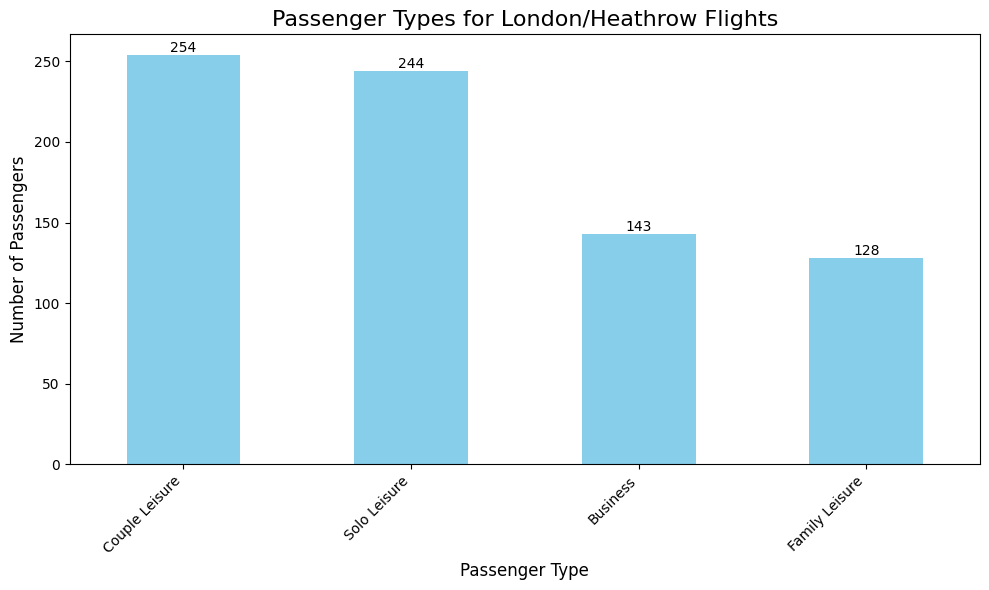

In [29]:
# Count the occurrences of each passenger type
passenger_type_counts = london_df['type'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
passenger_type_counts.plot(kind='bar', color='skyblue')

# Customize the chart
plt.title('Passenger Types for London/Heathrow Flights', fontsize=16)
plt.xlabel('Passenger Type', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(passenger_type_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

The data indicates a predominance of solo travelers and couples, suggesting a potential need for increased assistance and tailored services to cater to these passenger demographics. This insight could inform staffing decisions and service offerings to better accommodate the needs of these traveler types.

In [30]:
def filter_reviews_by_keyword(df, keyword='staff'):
    """
    Filter reviews containing a specific keyword and calculate the percentage.

    Args:
    - df (DataFrame): Input DataFrame with a 'review' column.
    - keyword (str): Word to search for in reviews. Default is 'staff'.

    Returns:
    - DataFrame: Filtered DataFrame containing only reviews with the keyword.
    """

    # Filter reviews containing the keyword (case-insensitive)
    filtered_df = df[df['review'].str.contains(keyword, case=False)]

    # Calculate percentage of reviews containing the keyword
    total_reviews = len(df)
    matching_reviews = len(filtered_df)
    percentage = (matching_reviews / total_reviews) * 100

    # Display the percentage
    print(f"Reviews containing '{keyword}': {percentage:.2f}% ({matching_reviews}/{total_reviews})")

    return filtered_df

In [31]:
staff_df = filter_reviews_by_keyword(london_df, 'staff')

Reviews containing 'staff': 35.06% (270/770)


## Time Series Analysis

In [32]:
# Convert 'Month Year Flown' column to datetime data type
df['month_year_fly'] = pd.to_datetime(df['month_year_fly'])

### Monthly Time Series

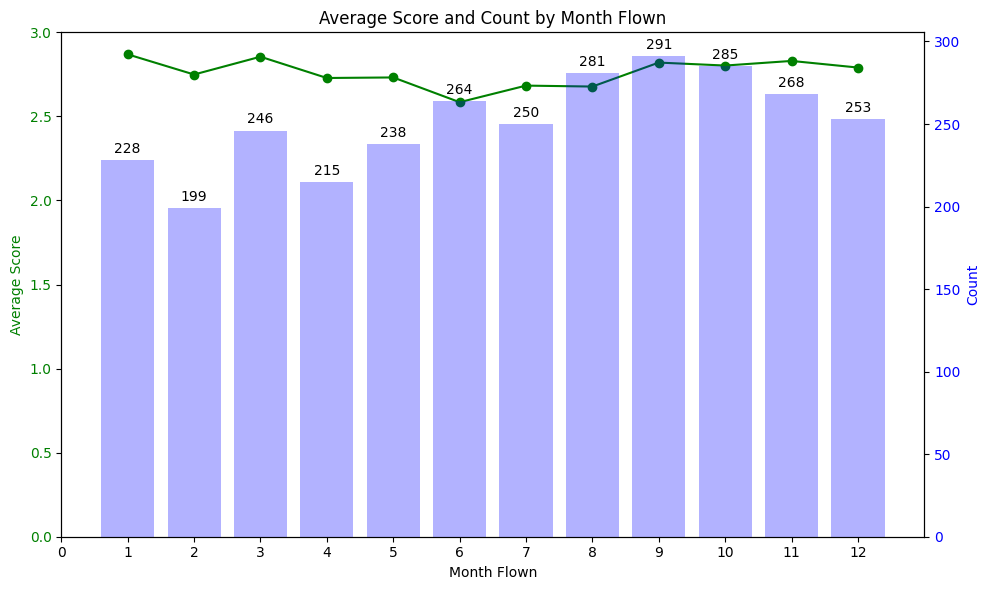

In [33]:
# Calculate average score and count by month
monthly_data = df.dropna(subset=['month_fly_num']).groupby('month_fly_num')['score'].agg(['mean', 'count']).sort_index()

# Create plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot average score
ax1.plot(monthly_data.index, monthly_data['mean'], color='green', marker='o', linestyle='-')
ax1.set_xlabel('Month Flown')
ax1.set_ylabel('Average Score', color='green')
ax1.set_ylim(0, 3)
ax1.tick_params(axis='y', labelcolor='green')

# Plot count as bars
bars = ax2.bar(monthly_data.index, monthly_data['count'], color='blue', alpha=0.3)
ax2.set_ylabel('Count', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add count labels to bars
for bar in bars:
    ax2.annotate(f'{bar.get_height()}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Set title and x-axis
plt.title('Average Score and Count by Month Flown')
plt.xticks(range(13))
plt.xlim(0, 13)

plt.tight_layout()
plt.show()

The data suggests that summer months may present challenges or issues for the airline.

# Review Analysis

In [34]:
# Standard library imports
import os, csv, re
from collections import Counter
from io import StringIO

# Third-party imports
import nltk, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, boto3
from scipy.stats import shapiro
from textblob import TextBlob
from wordcloud import WordCloud

# NLTK specific imports
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, opinion_lexicon
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk import pos_tag

# Download NLTK resources and suppress warnings
nltk.download(['punkt', 'stopwords', 'vader_lexicon', 'averaged_perceptron_tagger', 'opinion_lexicon'])
import warnings
warnings.filterwarnings("ignore")

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is

True

In [35]:
# Initialize a session using Amazon S3
s3_client = boto3.client('s3', 
                         aws_access_key_id=os.getenv('aws_access_key_id'),
                         aws_secret_access_key=os.getenv('aws_secret_access_key'))

# Name of the S3 bucket
bucket_name = 'new-british-airline'

def get_recent_csv_files(bucket_name, num_files=2):
    response = s3_client.list_objects_v2(Bucket=bucket_name)
    csv_files = [
        {'Key': obj['Key'], 'LastModified': obj['LastModified']}
        for obj in response.get('Contents', [])
        if obj['Key'].endswith('.csv')
    ]
    return [file['Key'] for file in sorted(csv_files, key=lambda x: x['LastModified'], reverse=True)[:num_files]]

def read_csv_to_df(bucket_name, file_key):
    csv_obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    return pd.read_csv(StringIO(csv_obj['Body'].read().decode('utf-8')))

# Get the most recent CSV file and read it into a DataFrame
recent_csv_file = get_recent_csv_files(bucket_name, num_files=1)[0]
df = read_csv_to_df(bucket_name, recent_csv_file)

In [36]:
df.head()

,id,date_review,day_review,month_review,month_review_num,year_review,verified,name,month_fly,month_fly_num,...,seat_comfort,cabin_serv,food,ground_service,wifi,money_value,score,experience,recommended,review
0,0,2024-09-28,28,September,9,2024,True,Christopher Neep,September,9.0,...,4.0,5.0,2.0,3.0,NaN,2,3.5,Poor,True,British Airways World Traveller Plus (Premium ...
1,1,2024-09-25,25,September,9,2024,True,D Hane,September,9.0,...,3.0,4.0,1.0,3.0,1.0,1,2.4,Poor,False,BA is barely a step above low cost airlines. T...
2,2,2024-09-24,24,September,9,2024,False,John Brown,September,9.0,...,5.0,5.0,5.0,5.0,NaN,5,5.0,Good,True,Happy with the flight crew. Hadn't been on a p...
3,3,2024-09-22,22,September,9,2024,True,C Haddei,September,9.0,...,1.0,NaN,NaN,1.0,NaN,1,1.0,Poor,False,Horrible service from boarding to landing. I f...
4,4,2024-09-13,13,September,9,2024,False,Thomas Wilson,September,9.0,...,2.0,2.0,2.0,1.0,2.0,1,1.8,Poor,False,My wife and I are very disappointed with flyin...


In [37]:
df = df[['seat_comfort', 'cabin_serv', 'food','ground_service', 'wifi','review', 'money_value','recommended']]

In [38]:
df.head()

,seat_comfort,cabin_serv,food,ground_service,wifi,review,money_value,recommended
0,4.0,5.0,2.0,3.0,NaN,British Airways World Traveller Plus (Premium ...,2,True
1,3.0,4.0,1.0,3.0,1.0,BA is barely a step above low cost airlines. T...,1,False
2,5.0,5.0,5.0,5.0,NaN,Happy with the flight crew. Hadn't been on a p...,5,True
3,1.0,NaN,NaN,1.0,NaN,Horrible service from boarding to landing. I f...,1,False
4,2.0,2.0,2.0,1.0,2.0,My wife and I are very disappointed with flyin...,1,False


## General Word Frequency Analysis

In [39]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [40]:
def negative_word_cloud(df):
    # Combine all reviews into a single string
    reviews_text = ' '.join(df['review'].dropna())

    # Tokenize and preprocess the text
    tokens = word_tokenize(reviews_text.lower())
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Perform sentiment analysis to identify negative words
    sid = SentimentIntensityAnalyzer()
    negative_words = [word for word in filtered_tokens if sid.polarity_scores(word)['compound'] < -0.1]

    # Initialize stemmer and word groups
    stemmer = PorterStemmer()
    word_groups = {
        'delay': ['delayed', 'delays', 'delaying'],
        'cancel': ['cancelled', 'cancellation', 'cancelling'],
        'luggage': ['baggage', 'suitcase', 'bag'],
        'staff': ['crew', 'attendant', 'employee'],
        'uncomfortable': ['discomfort', 'unpleasant', 'cramped']
    }

    # Group and stem negative words
    word_count = {}
    for word in negative_words:
        stemmed_word = stemmer.stem(word)
        grouped_word = next((root for root, group in word_groups.items() if stemmed_word in group), stemmed_word)
        word_count[grouped_word] = word_count.get(grouped_word, 0) + 1

    # Print top 5 most common words
    top_5_words = sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:5]
    print("Top 5 most common negative words:")
    for word, count in top_5_words:
        print(f"{word}: {count}")

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=800, 
                          background_color='white', 
                          min_font_size=10,
                          colormap='Reds').generate_from_frequencies(word_count)

    # Display the word cloud
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Negative Word Cloud", fontsize=20)
    plt.tight_layout(pad=0)
    plt.show()

Top 5 most common negative words:
delay: 918
poor: 666
pay: 482
cancel: 477
disappoint: 441


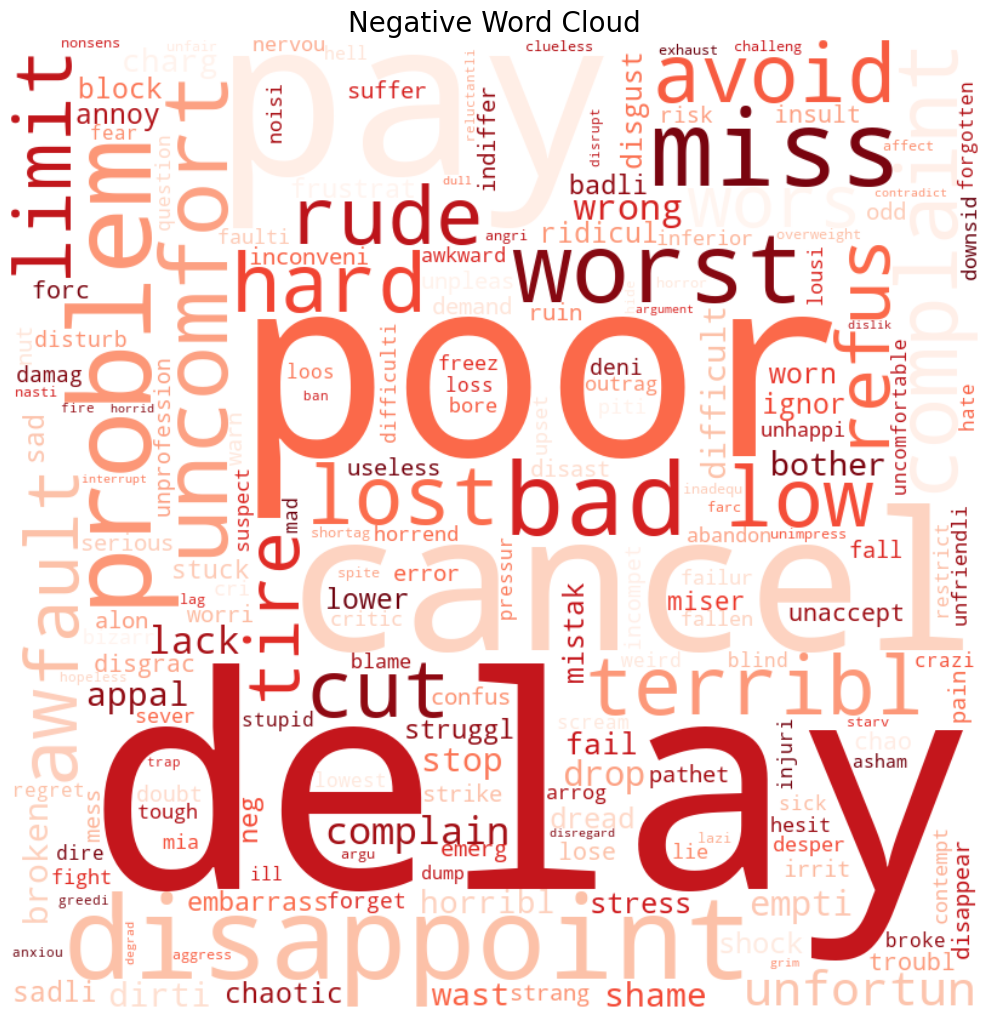

In [41]:
negative_word_cloud(df)

## Root Cause Analysis (London Experience Analysis)

In [42]:
# The target is people who are not recommended and have poor ground service and travelling through London Heathrow
target_df = london_df[(london_df['recommended'] == False) & (london_df['ground_service'] <= 3)]


In [43]:
def calculate_keyword_percentage(df, *keyword_groups):
    """
    Calculate the percentage of reviews containing specific keyword groups.

    Parameters:
    df (DataFrame): DataFrame with a 'review' column.
    *keyword_groups: Variable number of lists, each containing related keywords.

    Returns:
    None
    """
    for keywords in keyword_groups:
        # Check if all keywords in the group are present in the review
        df[f'contains_{keywords[0]}'] = df['review'].apply(
            lambda review: all(kw.lower() in review.lower() for kw in keywords)
        ).astype(int)
        
        # Calculate and display the percentage
        percentage = (df[f'contains_{keywords[0]}'].mean() * 100).round(2)
        print(f"Percentage of reviews mentioning {', '.join(keywords)}: {percentage}%")

In [44]:
# Calculate percentages for various issues
calculate_keyword_percentage(
    target_df,
    ["lost", "luggage"],
    ['miss', 'wait'],
    ["delay"],
    ['cancel'],
    ['uncomfortable', 'seat'],
    ['staff']
)

Percentage of reviews mentioning lost, luggage: 3.99%
Percentage of reviews mentioning miss, wait: 5.65%
Percentage of reviews mentioning delay: 30.99%
Percentage of reviews mentioning cancel: 18.46%
Percentage of reviews mentioning uncomfortable, seat: 6.06%
Percentage of reviews mentioning staff: 35.26%


Staff related issues are a major concern for British Airways customers

In [45]:
def extract_sentences_containing_word(df, input_word):
    """
    Return a DataFrame with sentences containing the input word in the 'review' DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing a 'review' column.
    input_word (str): The word to find the nearest sentences from.

    Returns:
    DataFrame: A DataFrame containing sentences with the input word.
    """
    # Regular expression pattern to split sentences by ., !, or ;
    pattern = r'(?<=[.!;,?])'

    sentences_list = []

    # Iterate through each review in the DataFrame
    for review in df['review']:
        # Split the review into sentences using the pattern
        review_sentences = re.split(pattern, review)

        # Iterate through each sentence in the review
        for sentence in review_sentences:
            # Check if the input word is in the sentence
            if input_word.lower() in sentence.lower():
                # Add the sentence to the list
                sentences_list.append(sentence.strip())

    # Create a DataFrame from the list of sentences
    sentences_df = pd.DataFrame(sentences_list, columns=['review'])

    print(f"A DataFrame containing sentences with '{input_word}' has been created.")
    return sentences_df

In [46]:
staff_sentences = extract_sentences_containing_word(target_df, 'staff')
staff_sentences.head()

A DataFrame containing sentences with 'staff' has been created.


,review
0,There was no member of staff present to offer ...
1,Many staff standing around doing very little a...
2,I was forced by the ground staff to check in m...
3,I was informed that the plane was full and ass...
4,all manual check in by understaffed BA staff w...


Top 5 most common negative words:
rude: 43
delay: 12
poor: 8
refus: 7
complaint: 7


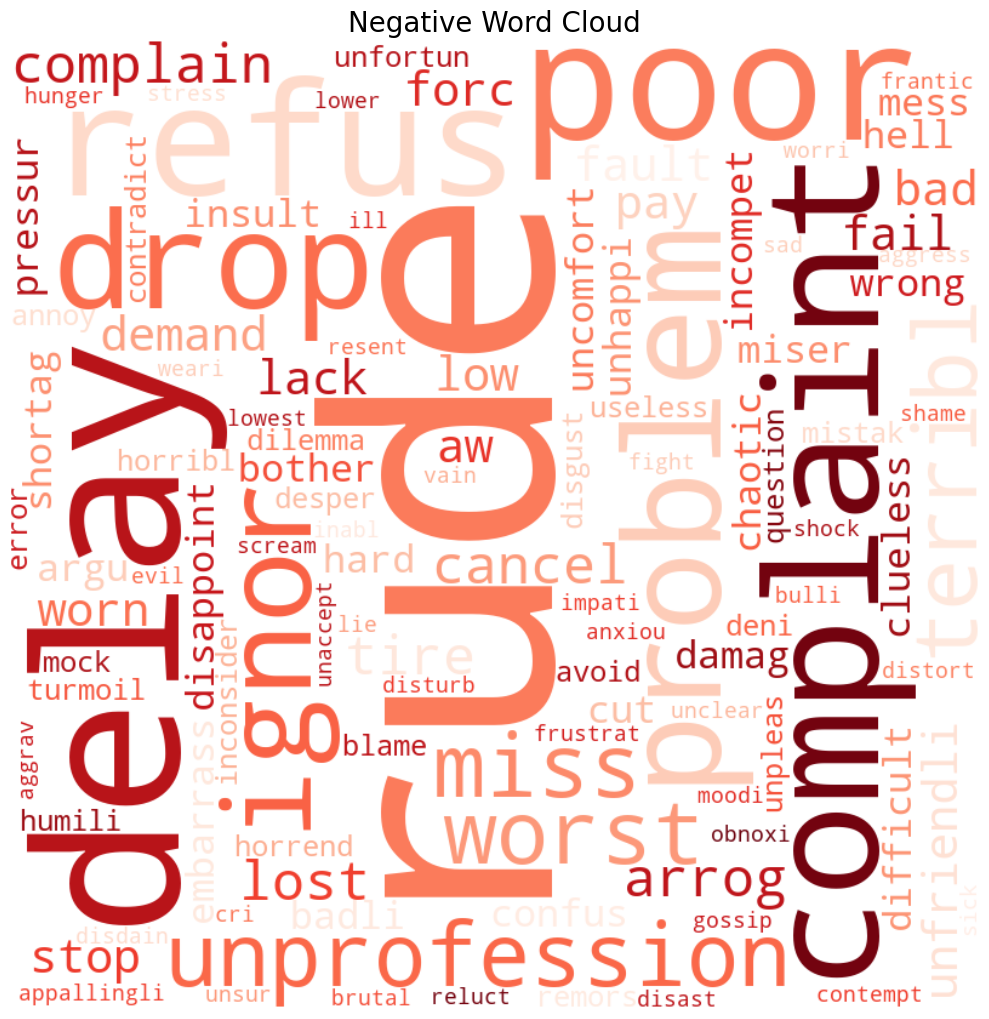

In [47]:
negative_word_cloud(staff_sentences)

## Topic Modelling
Topic Modeling: Categorizing Customer Reviews Related to Staff Issues. We will classify staff-related customer reviews into 3 main topics:
1. Staff Attitude: Reviews focusing on staff behavior and demeanor
2. Staffing Levels: Reviews mentioning insufficient staff or long wait times
3. Other Staff-Related Issues: Miscellaneous staff problems not fitting the above categories

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
# Extract sentences containing the word 'staff'
staff_sentences = extract_sentences_containing_word(target_df, 'staff')

# Preprocess the sentences
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    return ' '.join([word for word in tokens if word.isalnum() and word not in stop_words])

staff_sentences['processed_text'] = staff_sentences['review'].apply(preprocess_text)

# Vectorize the sentences using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(staff_sentences['processed_text'])

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Define custom labels for the clusters
cluster_labels = {0: 'Staff Attitude', 1: 'Lack of Staff', 2: 'Others'}

# Create a DataFrame with sentences and their assigned topics
classified_staff_problems_df = pd.DataFrame({
    'Sentence': staff_sentences['review'],
    'Topic': [cluster_labels[label] for label in kmeans.labels_]
})

# Print the top terms for each cluster
feature_names = vectorizer.get_feature_names_out()
for i, centroid in enumerate(kmeans.cluster_centers_):
    top_features = [feature_names[j] for j in centroid.argsort()[-10:][::-1]]
    print(f"Cluster {i} ({cluster_labels[i]}): {', '.join(top_features)}")

A DataFrame containing sentences with 'staff' has been created.
Cluster 0 (Staff Attitude): ba, staff, us, luggage, told, staffed, flight, check, asked, would
Cluster 1 (Lack of Staff): cabin, service, staff, rude, terrible, customer, poor, flight, care, bad
Cluster 2 (Others): staff, rude, ground, flight, friendly, british, check, airways, passengers, airport


In [53]:
# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the data directory
data_dir = os.path.join(os.path.dirname(current_dir), 'data')

# Ensure the data directory exists
os.makedirs(data_dir, exist_ok=True)

# Set the full path for the CSV file
csv_path = os.path.join(data_dir, 'classified_staff_problems.csv')

# Save the classified staff problems DataFrame to a CSV file in the data directory
classified_staff_problems_df.to_csv(csv_path, index=False)

# Display the first few rows of the DataFrame and the save location
print(f"Data saved to: {csv_path}")
print("\nFirst few rows of the DataFrame:")
print(classified_staff_problems_df.head())

Data saved to: c:\Users\hamin\Desktop\British-Airway\data\classified_staff_problems.csv

First few rows of the DataFrame:
                                            Sentence           Topic
0  There was no member of staff present to offer ...   Lack of Staff
1  Many staff standing around doing very little a...          Others
2  I was forced by the ground staff to check in m...          Others
3  I was informed that the plane was full and ass...  Staff Attitude
4  all manual check in by understaffed BA staff w...  Staff Attitude


# Key Insights from British Airways EDA

## 1. Service Quality
- **Cabin service** has the highest mean rating among all service aspects.
- **WiFi** and **food services** have the lowest mean ratings, indicating areas for improvement.

## 2. Customer Satisfaction
- The distribution of scores is skewed towards lower ratings, suggesting overall customer dissatisfaction.
- Strong positive correlation between sentiment score and overall score, validating the sentiment analysis approach.

## 3. Class-specific Factors
- **Non-economy class**: Food/beverages and seat comfort are key satisfaction factors.
- **Economy class**: Ground service is the primary factor affecting satisfaction.

## 4. London/Heathrow Issues
- Significant poor ground service ratings associated with London airports, particularly Heathrow and Gatwick.
- Solo travelers and couples are the predominant passenger types reporting issues at London airports.

## 5. Seasonal Trends
- Summer months show lower average scores and higher passenger counts, suggesting potential challenges during peak travel seasons.

## 6. Negative Feedback Analysis
Common negative terms include:
- Delay
- Cancel
- Luggage
- Staff
- Uncomfortable

## 7. Staff-related Issues
- Major concern with a significant percentage of negative reviews mentioning staff.
- Staff issues categorized into three main topics:
  1. Staff Attitude
  2. Staffing Levels
  3. Other Staff-Related Issues

## 8. Ground Service
- Critical pain point for economy class passengers, especially at London airports.

## 9. Sentiment Analysis
- Correlation between sentiment scores derived from reviews and overall numerical scores given by passengers.

## 10. Time Series Patterns
- Monthly fluctuations in average scores and passenger counts, with potential seasonal effects.

## Recommendations
British Airways should focus on:
1. Improving ground services, especially at London airports
2. Addressing staff-related issues
3. Enhancing food and WiFi services
4. Preparing for increased demands during summer months
5. Tailoring services for different passenger classes and types (e.g., solo travelers, couples)

These actions could lead to improved customer satisfaction and overall service quality.